<a href="https://colab.research.google.com/github/japashira/sprint4_ia/blob/main/Sprint4_IA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sprint 4 – DentalCare | Agendamento com IA Preditiva

Instalação das bibliotecas necessárias

In [ ]:
!pip install -q flask joblib scikit-learn pandas numpy matplotlib seaborn requests

Importação das bibliotecas

In [ ]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from flask import Flask, request, jsonify
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from werkzeug.serving import run_simple
import threading
import requests

Geração da base de dados

In [ ]:
np.random.seed(42)
num_samples = 2000

dados = {
    'idade': np.random.randint(18, 70, num_samples),
    'frequencia_consultas': np.random.randint(1, 10, num_samples),
    'procedimento_preventivo': np.random.choice([0, 1], num_samples),
    'historico_cancelamentos': np.random.randint(0, 5, num_samples),
    'valor_gasto': np.random.randint(50, 500, num_samples),
    'consulta_desnecessaria': np.random.choice([0, 1], num_samples, p=[0.7, 0.3])
}

df = pd.DataFrame(dados)
df.head()

,idade,frequencia_consultas,procedimento_preventivo,historico_cancelamentos,valor_gasto,consulta_desnecessaria
0,56,5,0,3,160,0
1,69,8,1,3,387,0
2,46,3,1,4,172,0
3,32,4,1,2,242,0
4,60,9,0,0,496,0


Análise e visualização dos dados

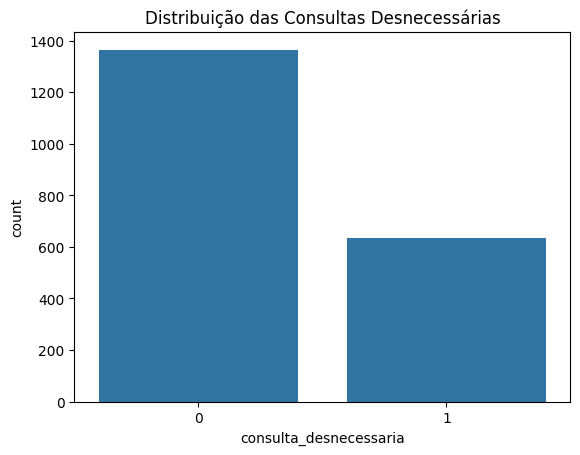

,idade,frequencia_consultas,procedimento_preventivo,historico_cancelamentos,valor_gasto,consulta_desnecessaria
count,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000,2000.00000
mean,43.805500,5.00550,0.499000,2.028000,276.246500,0.31750
std,14.929203,2.57406,0.500124,1.410394,128.145255,0.46562
min,18.000000,1.00000,0.000000,0.000000,50.000000,0.00000
25%,31.000000,3.00000,0.000000,1.000000,165.000000,0.00000
50%,44.000000,5.00000,0.000000,2.000000,277.000000,0.00000
75%,56.000000,7.00000,1.000000,3.000000,385.000000,1.00000
max,69.000000,9.00000,1.000000,4.000000,499.000000,1.00000


In [ ]:
sns.countplot(x='consulta_desnecessaria', data=df)
plt.title("Distribuição das Consultas Desnecessárias")
plt.show()

df.describe()

Separação dos dados para treino e teste

In [ ]:
X = df.drop('consulta_desnecessaria', axis=1)
y = df['consulta_desnecessaria']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Treinamento e comparação entre dois modelos

In [ ]:
# Modelos
model_rf = RandomForestClassifier(random_state=42)
model_gb = GradientBoostingClassifier(random_state=42)

# Validação cruzada
scores_rf = cross_val_score(model_rf, X_train, y_train, cv=5)
scores_gb = cross_val_score(model_gb, X_train, y_train, cv=5)

print("Random Forest - Acurácia média:", scores_rf.mean())
print("Gradient Boosting - Acurácia média:", scores_gb.mean())

Random Forest - Acurácia média: 0.625625
Gradient Boosting - Acurácia média: 0.6681250000000001


Escolha e treino do melhor modelo (Random Forest)

In [ ]:
param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

modelo_final = grid_search.best_estimator_
joblib.dump(modelo_final, 'modelo_dentalcare.pkl')

['modelo_dentalcare.pkl']

Avaliação do modelo

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.69      0.95      0.80       275
           1       0.26      0.04      0.07       125

    accuracy                           0.67       400
   macro avg       0.47      0.49      0.43       400
weighted avg       0.55      0.67      0.57       400



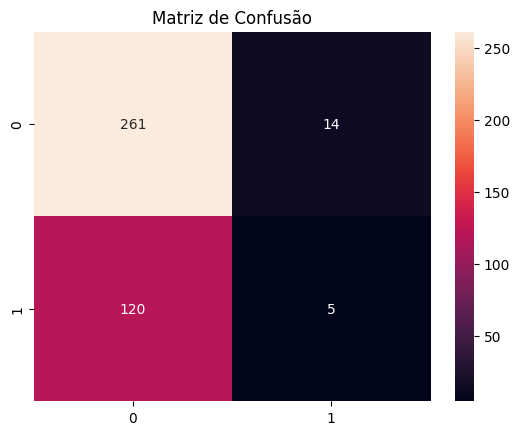

In [ ]:
y_pred = modelo_final.predict(X_test)

print("Relatório de Classificação:")
print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.title("Matriz de Confusão")
plt.show()

API Flask local para testes

In [ ]:
app = Flask(__name__)
modelo = joblib.load('modelo_dentalcare.pkl')

@app.route('/prever', methods=['POST'])
def prever():
    dados = request.json
    entrada = np.array([
        dados['idade'],
        dados['frequencia_consultas'],
        dados['procedimento_preventivo'],
        dados['historico_cancelamentos'],
        dados['valor_gasto']
    ]).reshape(1, -1)

    resultado = modelo.predict(entrada)
    return jsonify({'consulta_desnecessaria': int(resultado[0])})

def iniciar_api():
    run_simple('localhost', 5000, app)

thread = threading.Thread(target=iniciar_api)
thread.start()

Teste da API local com um exemplo de paciente

In [ ]:
paciente_exemplo = {
    "idade": 40,
    "frequencia_consultas": 2,
    "procedimento_preventivo": 1,
    "historico_cancelamentos": 0,
    "valor_gasto": 120
}

resposta = requests.post("http://localhost:5000/prever", json=paciente_exemplo)
print("Resultado da Previsão:", resposta.json())

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
INFO:werkzeug:127.0.0.1 - - [23/May/2025 01:09:26] "POST /prever HTTP/1.1" 200 -


Resultado da Previsão: {'consulta_desnecessaria': 0}
